In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from spec_id import *
from sim_engine import *
from spec_stats import Highest_density_region, Linear_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from prospect.models.transforms import logsfr_ratios_to_masses
from time import time
import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [6]:
### good sample
fields = ['GND', 'GND', 'GND', 'GND', 'GND', 'GND', 'GND', 'GND', 'GND', 'GND', 
          'GND', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', 'GSD', ]
ids = [12078, 15490, 16758, 21156, 22213, 22246, 23081, 23104, 37340, 37686, 37813, 39170, 
       39241, 39364, 39804, 40597, 41148, 41520, 42113, 44042]

In [11]:
goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodss_eazy = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                         format='fits').to_pandas()
goodsn_eazy = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                         format='fits').to_pandas()

In [17]:
int(os.path.basename(llist[0]).split('_')[1])

12078

In [18]:
Reff = []
lmass = []
rshift = []
llist = glob('../data/posteriors/G*_tabfit_Plm.npy')
zlist = glob('../data/posteriors/G*_tabfit_Plm.npy')

for i in range(len(zlist)):
    x,px = np.load(zlist[i])
    rshift.append(x[px==px.max()][0])
    x,px = np.load(llist[i])
    lmass.append(x[px==px.max()][0])
    
    ids = int(os.path.basename(llist[0]).split('_')[1])

    if os.path.basename(llist[0]).split('_')[0][1] == 'S':
        r = goodss_rad.re[goodss_rad.NUMBER == ids].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == ids].values)
        Reff.append(r[0])
        
    if os.path.basename(llist[0]).split('_')[0][1] == 'N':
        r = goodsn_rad.re[goodsn_rad.NUMBER == ids].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == ids].values)
        Reff.append(r[0])


In [6]:
G_gals = pd.DataFrame({'field':fields, 'id':ids, 'zgrism':rshift, 'mass':lmass, 'lmass':np.log10(lmass)})

# Examine fits

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


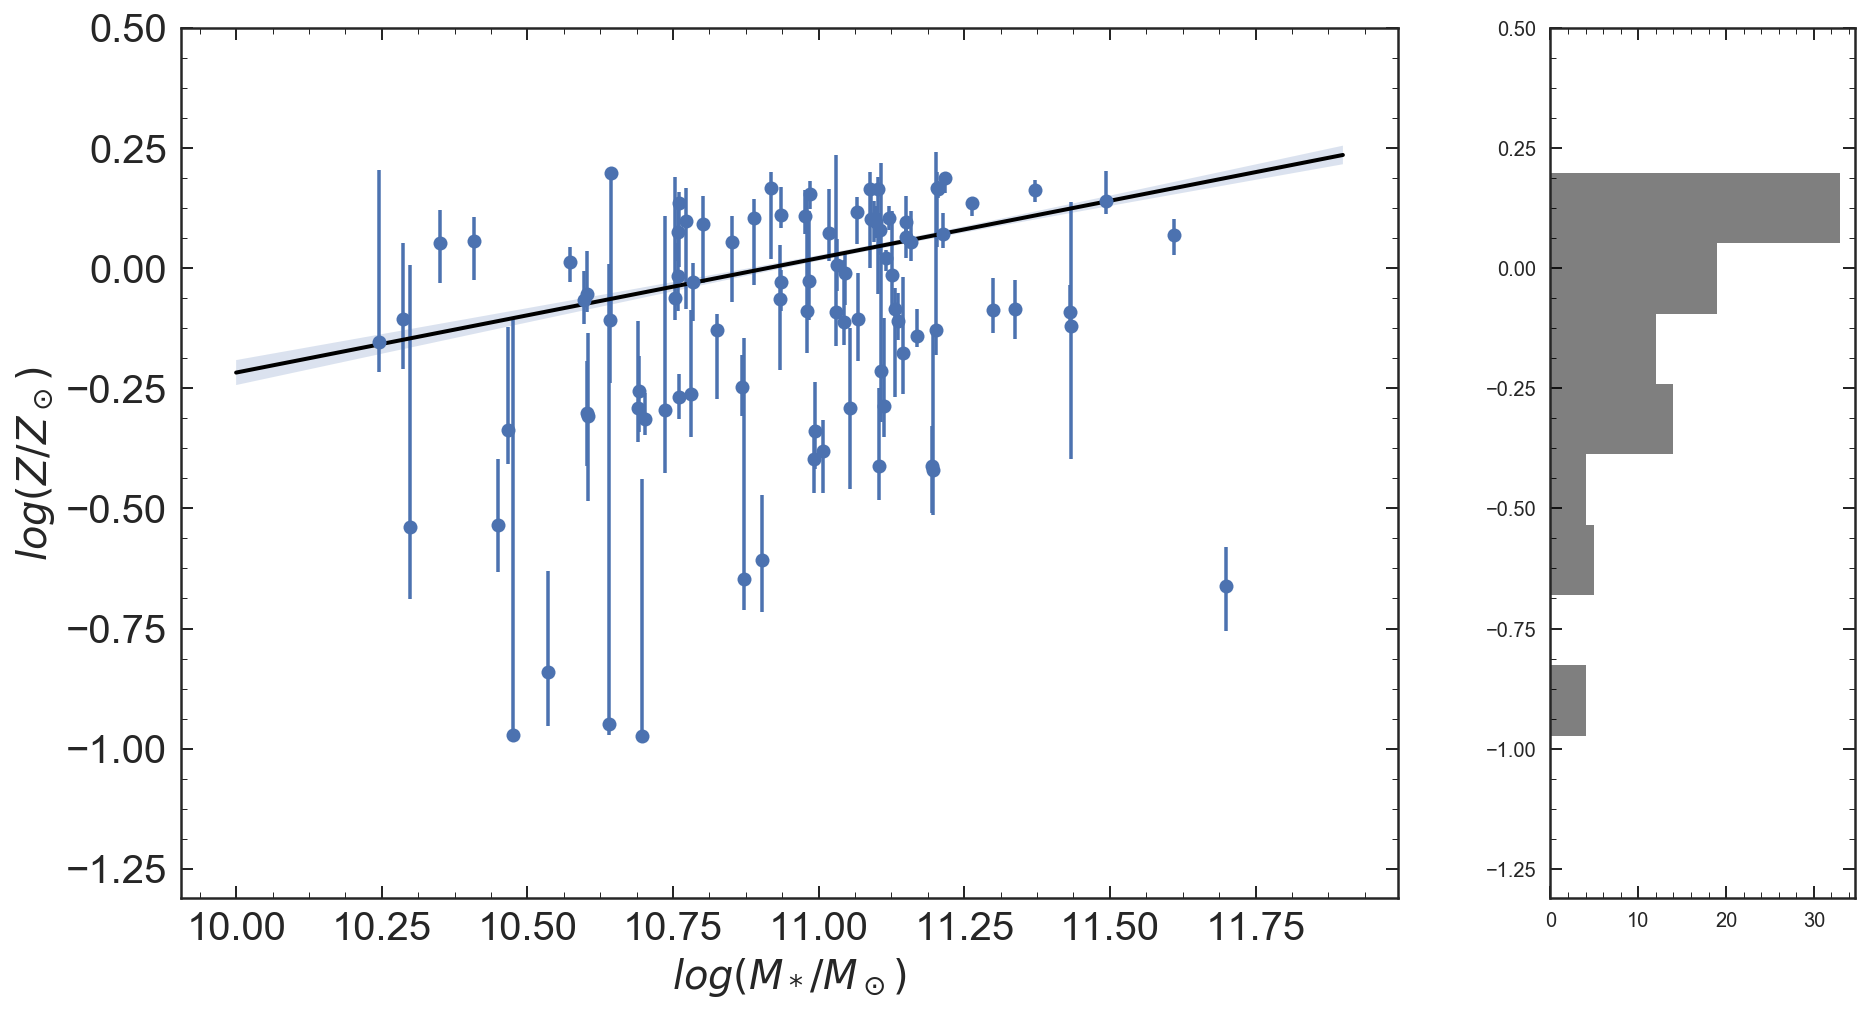

In [2]:
plist = glob('../data/posteriors/G*_tabfit_Pm.npy')
llist = glob('../data/posteriors/G*_tabfit_Plm.npy')

tmed,tle,the = np.zeros([3,len(plist)])
dmed,dle,dhe = np.zeros([3,len(plist)])

gs= GridSpec(1,2,width_ratios=[4,1])

plt.figure(figsize=[15,8])
plt.subplot(gs[0])

for i in range(len(plist)):
    t,pt = np.load(plist[i])
    d,pd = np.load(llist[i])
    tmed[i],tle[i],the[i] = Highest_density_region(pt,t)
    dmed[i],dle[i],dhe[i] = Highest_density_region(pd,d)

plt.errorbar(dmed,np.log10(tmed), yerr=[tle / (tmed*np.log(10)),the/ (tmed*np.log(10))], fmt='o')
plt.ylim(-1.31,.5)

    
errs = ((tle + the)/2) / (tmed * np.log(10))
samp = np.arange(10,11.9,.01)
lfit,lfit_errs,cov = Linear_fit(dmed,np.log10(tmed),errs,samp,return_cov=True)

plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')
plt.xlabel('$log(M_*/M_\odot)$', fontsize=20)
plt.ylabel('$log(Z/Z_\odot)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.subplot(gs[1])
sea.distplot(np.log10(tmed),
             vertical=True,kde=False,hist_kws={"histtype": "stepfilled", "linewidth": 3,"alpha": 0.5,"color":'k'})
plt.ylim(-1.31,.5)

plt.savefig('../plots/new_MM.png' ,bbox_inches = 'tight')

In [5]:
tmed,tle,the = np.zeros([3,len(fields)])
dmed,dle,dhe = np.zeros([3,len(fields)])

for i in G_gals.index:
    t,pt = np.load('../data/posteriors/{0}_{1}_tabfit_Pm.npy'.format(G_gals.field[i], G_gals.id[i]))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Pm.npy'.format(G_gals.field[i], G_gals.id[i]))
    tmed[i],tle[i],the[i] = Highest_density_region(pt,t)
    dmed[i],dle[i],dhe[i] = Highest_density_region(pd,d)


plt.figure(figsize=[8,8])
plt.errorbar(G_gals.lmass,np.log10(tmed), yerr=[tle / (tmed*np.log(10)),the/ (tmed*np.log(10))], fmt='o')

plt.figure(figsize=[8,8])
plt.errorbar(G_gals.lmass,np.log10(dmed), yerr=[dle / (dmed*np.log(10)),dhe/ (dmed*np.log(10))], fmt='o')


NameError: name 'fields' is not defined

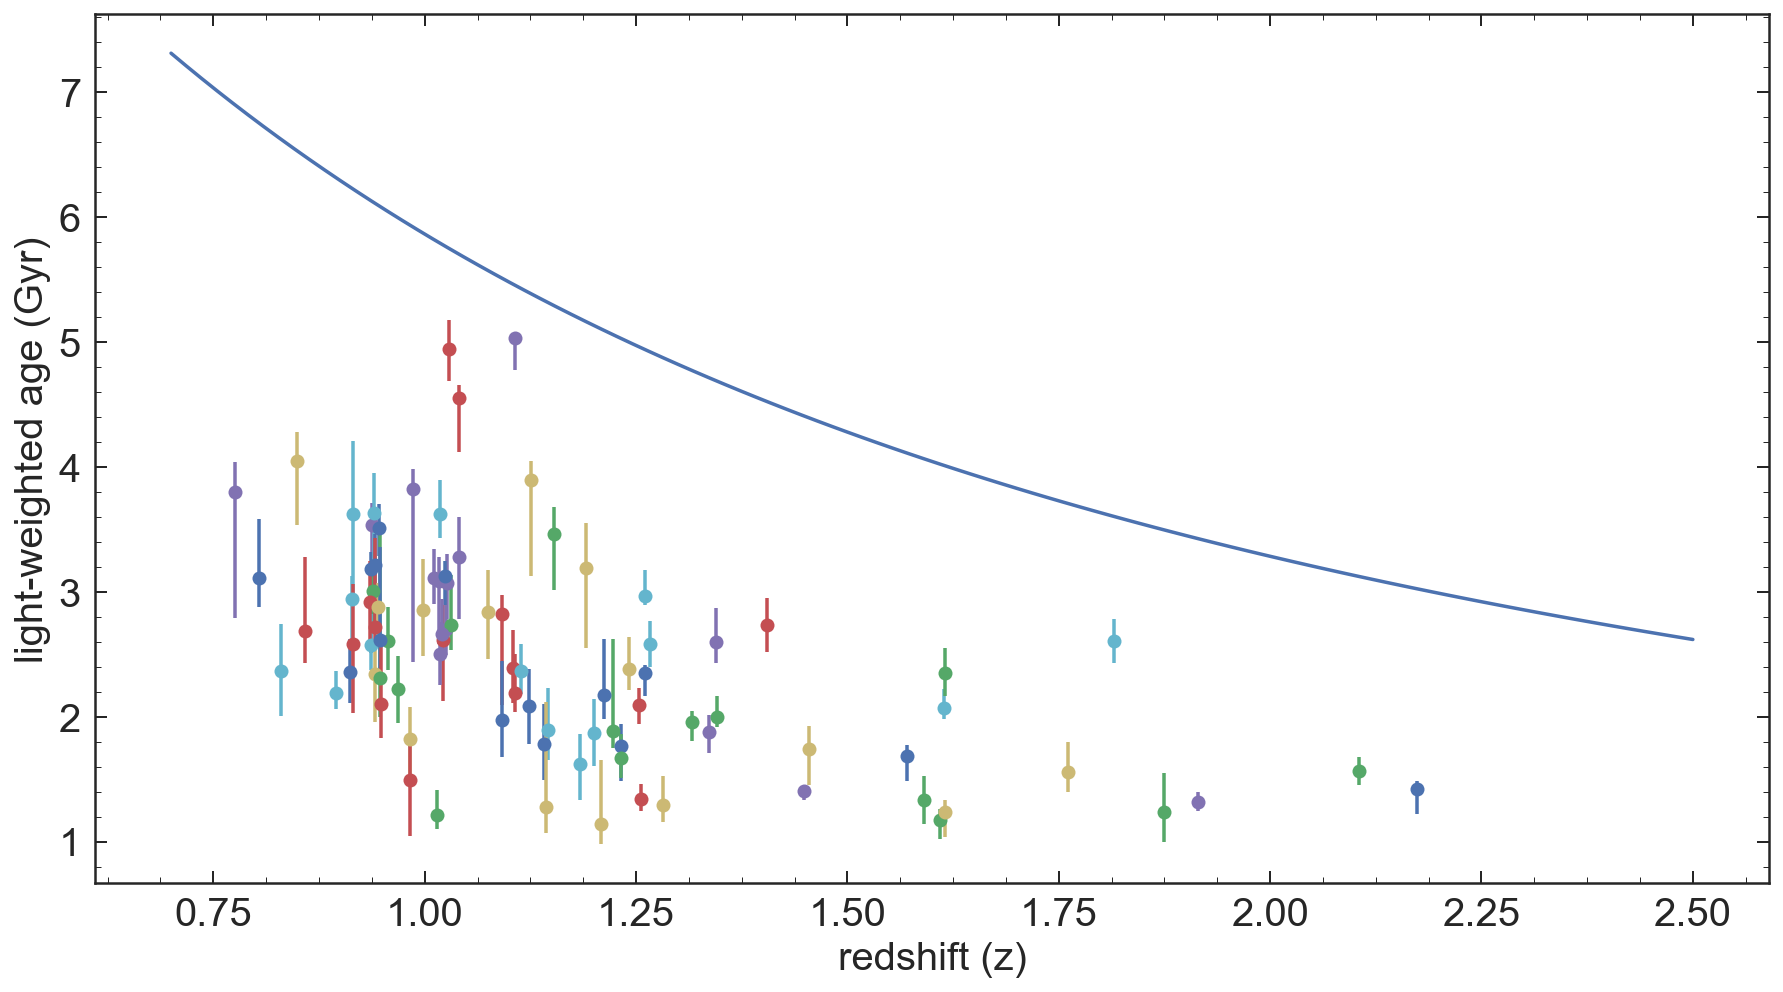

In [3]:
plist = glob('../data/posteriors/G*_tabfit_Plwa.npy')
llist = glob('../data/posteriors/G*_tabfit_Pz.npy')

z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

for i in range(len(plist)):
    t,pt = np.load(plist[i])
    d,pd = np.load(llist[i])
    tmed,tle,the = Highest_density_region(pt,t)
    dmed,dle,dhe = Highest_density_region(pd,d)

    plt.errorbar(dmed,tmed, yerr=[[tle],[the]], fmt='o')
    
plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/new_lwa.png' ,bbox_inches = 'tight')

In [2]:

def PLOT(field, galaxy, savefig = False):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bsc, rsc, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    
    
    Gs = Gen_spec(field, galaxy, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.04, irac_err = 0.08, decontam = True) 

    Gs.Sim_all_premade(wave*(1+z),flux)
    
    if Gs.g102:
        bcal = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Gs.Bmfl, bp1)[0]

    if Gs.g141:
        rcal = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Gs.Rmfl, rp1)[0]
    
    gs = GridSpec(3,4, hspace=0.3, wspace = 0.3)   

    plt.figure(figsize=[16,15])
    ###############plot tab##################
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / bcal,Gs.Ber*1E18 / bcal,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  rcal,Gs.Rer*1E18 / rcal,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    med,le,he = np.zeros([3,10])
    for i in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy,i+1))
        med[i],le[i],he[i] = Highest_density_region(px,x)

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
    a,ale,ahe = Highest_density_region(px,x)

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
    time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9) 
    
    plt.subplot(gs[0,3])
    plt.plot(time,sfr, 'r')
    plt.fill_between(time,sfr_l, sfr_h, alpha = 0.3)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############plot delay################
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.01, dust_type = 1)
    m, a, tau, lm, z, d, bsc, rsc, bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_delayfit_bfit.npy'.format(field, galaxy))
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)
    sp.params['tau'] = tau
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)    
    
    Gs = Gen_spec(field, galaxy, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.04, irac_err = 0.08, decontam = True) 

    Gs.Sim_all_premade(wave*(1+z),flux)
    
    if Gs.g102:
        bcal = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Gs.Bmfl, bp1)[0]

    if Gs.g141:
        rcal = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Gs.Rmfl, rp1)[0]
        
    plt.subplot(gs[1,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / bcal,Gs.Ber*1E18 / bcal,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  rcal,Gs.Rer*1E18 / rcal,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    x,px = np.load('../data/posteriors/{0}_{1}_delayfit_Pt.npy'.format(field, galaxy))
    tau, taul, tauh = Highest_density_region(px,x)

    x,px = np.load('../data/posteriors/{0}_{1}_delayfit_Pa.npy'.format(field, galaxy))
    a,ale,ahe = Highest_density_region(px,x)

    t = np.arange(0,a,0.01)
    sfr = t*np.exp( -t / tau) / np.trapz(t*np.exp( -t / tau),t)
    sfrl = t*np.exp( -t /(tau - taul)) / np.trapz(t*np.exp( -t /(tau - taul)),t)
    sfrh = t*np.exp( -t / (tau + tauh)) /  np.trapz(t*np.exp( -t / (tau + tauh)),t)
   
    plt.subplot(gs[1,3])
    plt.plot(t,sfr,'b')
    plt.fill_between(t,sfrl, sfrh, alpha = 0.3)
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('SFR', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(Z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pm.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Pm.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,0])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Z / Z$_\odot$', fontsize=15)
    plt.ylabel('P(Z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(lwa)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Plwa.npy'.format(field, galaxy))

    plt.subplot(gs[2,1])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Age', fontsize=15)
    plt.ylabel('P(lwa)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(z)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Pz.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,2])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('redshift', fontsize=15)
    plt.ylabel('P(z)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    ###############P(d)################
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pd.npy'.format(field, galaxy))
    d,pd = np.load('../data/posteriors/{0}_{1}_delayfit_Pd.npy'.format(field, galaxy))
    
    plt.subplot(gs[2,3])
    plt.plot(z,pz,'r')
    plt.plot(d,pd,'b')
    plt.xlabel('Av', fontsize=15)
    plt.ylabel('P(Av)', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    
    if savefig:
        plt.savefig('../plots/fullfits/all_data_{0}_{1}.png'.format(field, galaxy),bbox_inches = 'tight')

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


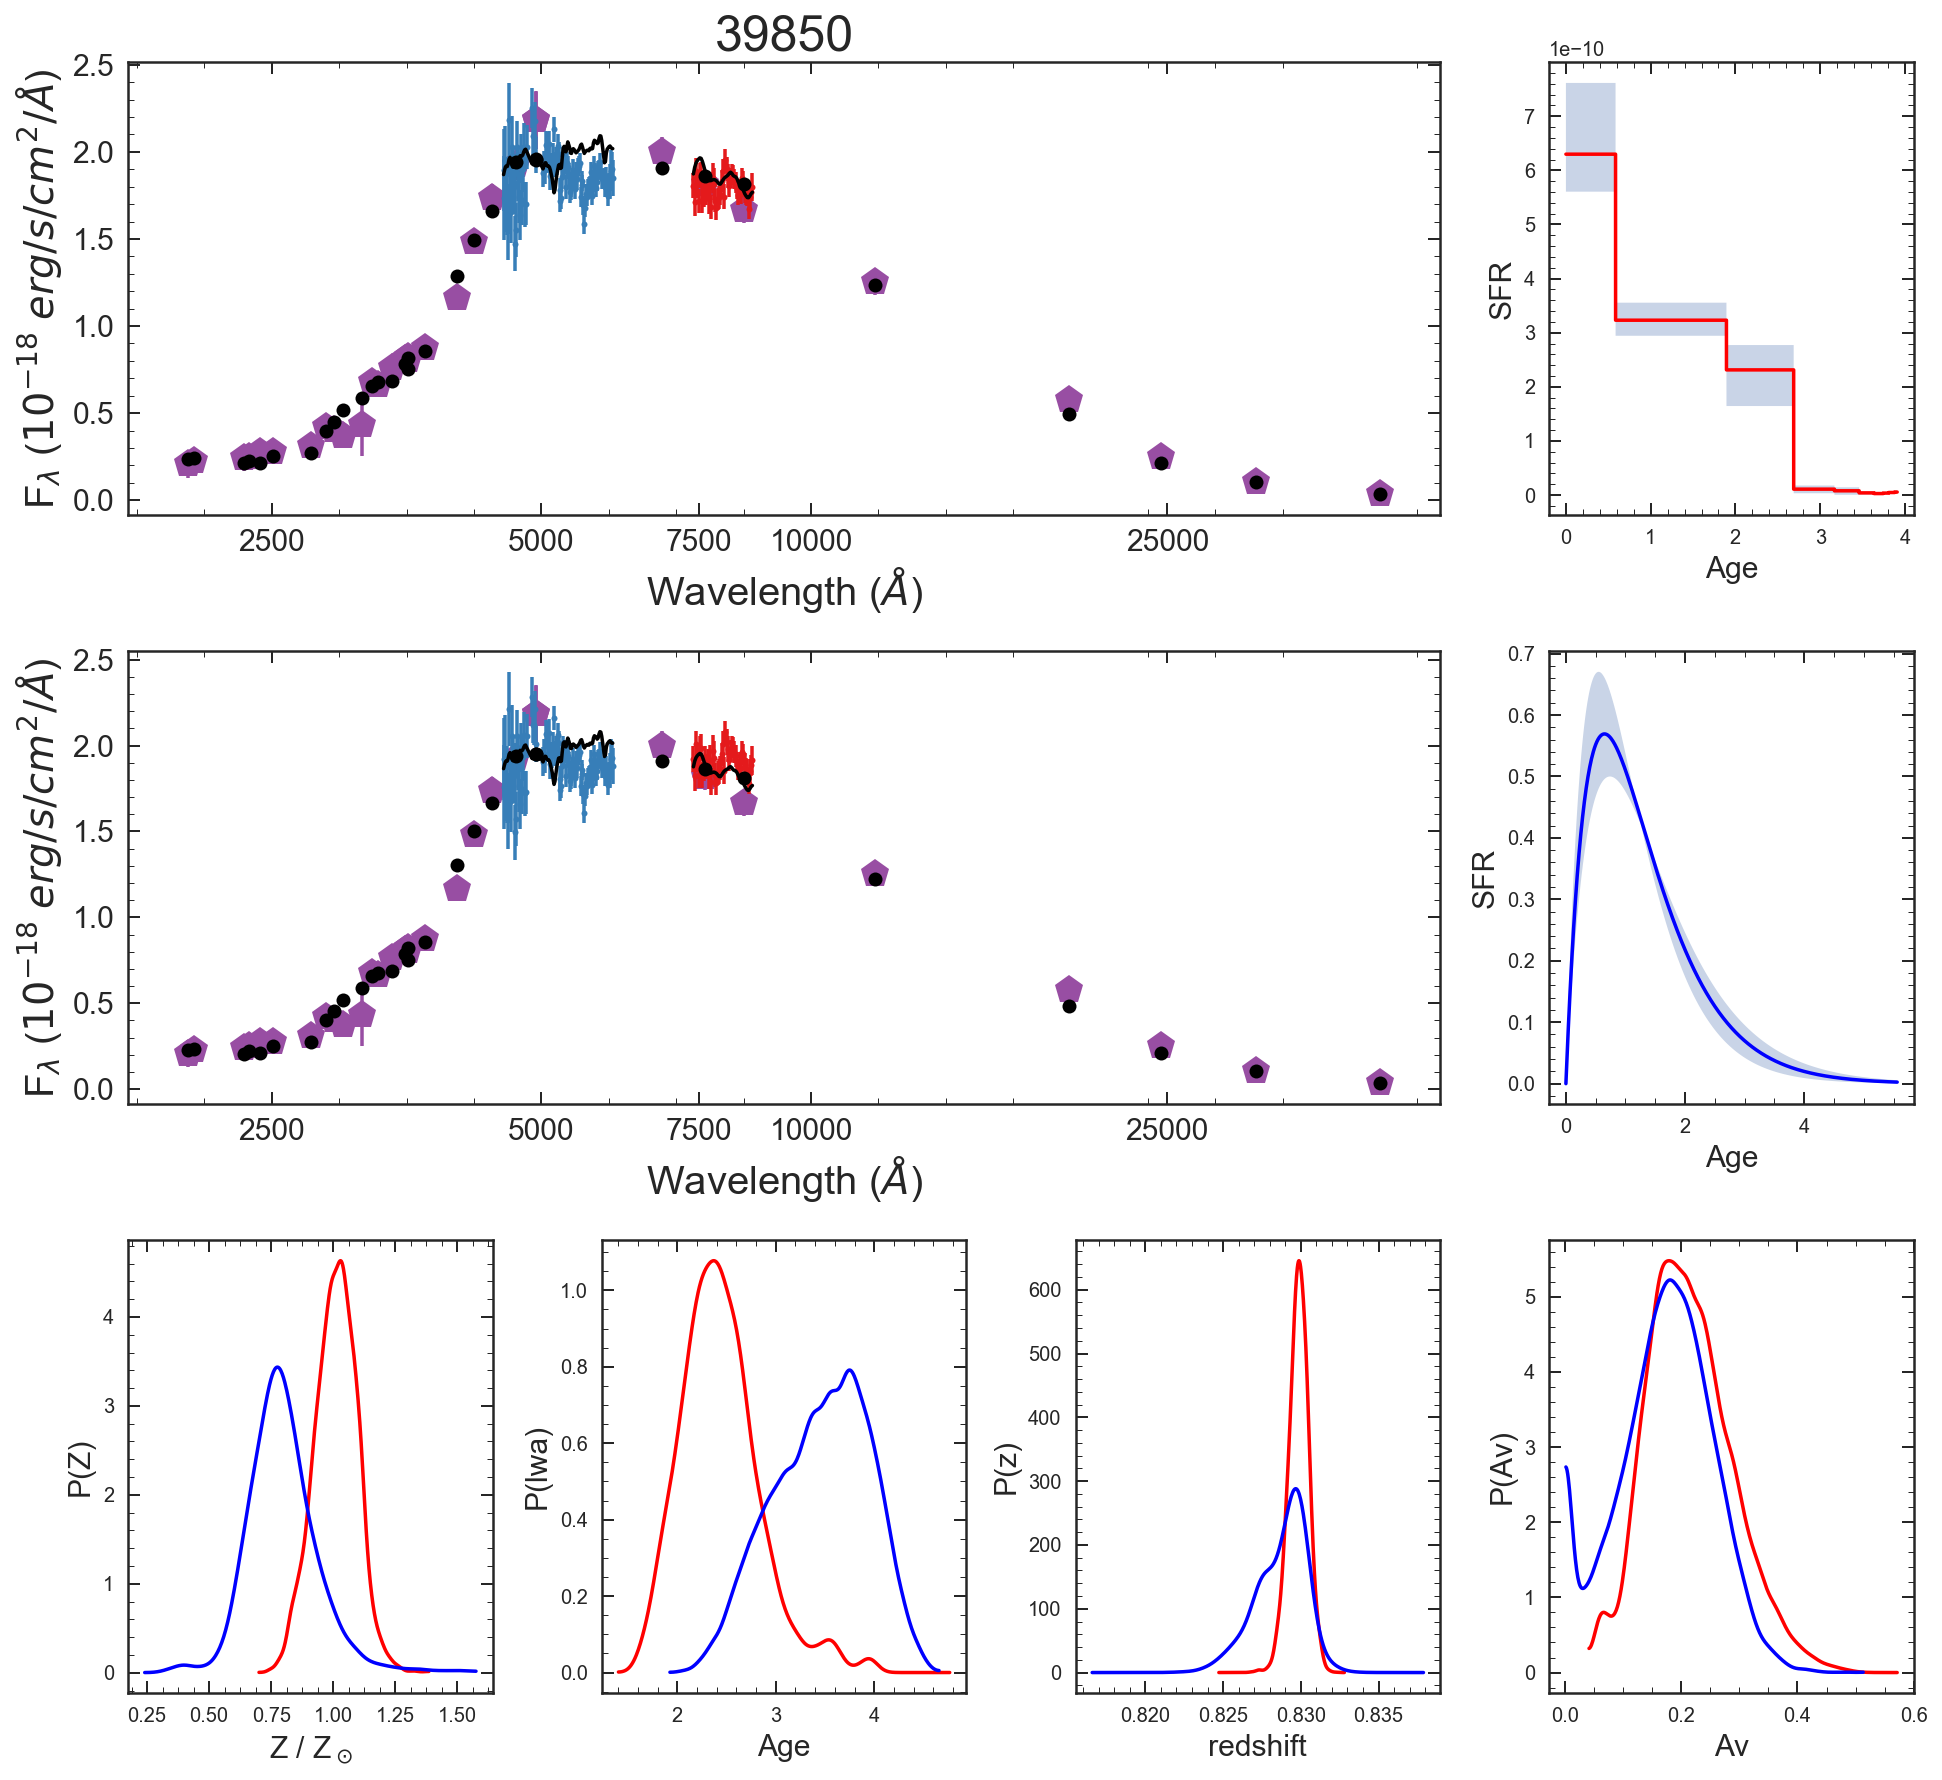

In [3]:
PLOT('GSD', 39850, savefig=False)

In [2]:
flist = glob('../data/posteriors/*zfit*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [3]:
for i in range(len(fld)):
    PLOT(fld[i], [i], savefig=True)

array([12078, 12793, 13182, 13774, 14158, 14713, 15490, 15901, 16758,
       17070, 17194, 17436, 20432, 21156, 22213, 22246, 22633, 23081,
       23104, 23459, 23490, 23631, 23758, 24177, 24795, 26673, 27185,
       27458, 27714, 27951, 29464, 30358, 32108, 33453, 33780, 34694,
       36102, 36161, 36348, 36530, 37180, 37186, 37189, 37210, 37232,
       37340, 37686, 37813, 37955, 18642, 19148, 23421, 25641, 26139,
       26915, 30144, 31397, 32799, 35046, 35774, 36095, 38191, 38472,
       38785, 39170, 39241, 39364, 39631, 39804, 39805, 39850, 40476,
       40597, 40623, 40862, 41148, 41520, 41886, 42113, 42221, 43615,
       44042, 44620, 44946, 45775, 45789, 45972, 47223, 47677, 47691,
       48631])

## Sample from posteriors

In [8]:
def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x)

In [12]:
ppf_dict = {}
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'z', 'd', 'bp1', 'rp1']

for i in params:
    x,px = np.load('../data/posteriors/GND_21156_tabfit_P{0}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)
    

In [13]:
x,px = np.load('../data/posteriors/GND_21156_tabfit_Pz.npy')
x[px == px.max()]

array([1.25352094])

In [14]:
Gs = Gen_spec('GND', 21156, 1.255, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False, phot_errterm = 0.04, 
              irac_err = 0.08, decontam = True) 
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [6]:
def Calibrate_grism(spec, Gmfl, p1):
    lines = (p1 * (spec[0] -(spec[0][-1] + spec[0][0])/2 ) + 1E3)
    scale = Scale_model(spec[1]  / lines, spec[2] / lines, Gmfl)    
    return scale * lines

ValueError: A value in x_new is below the interpolation range.

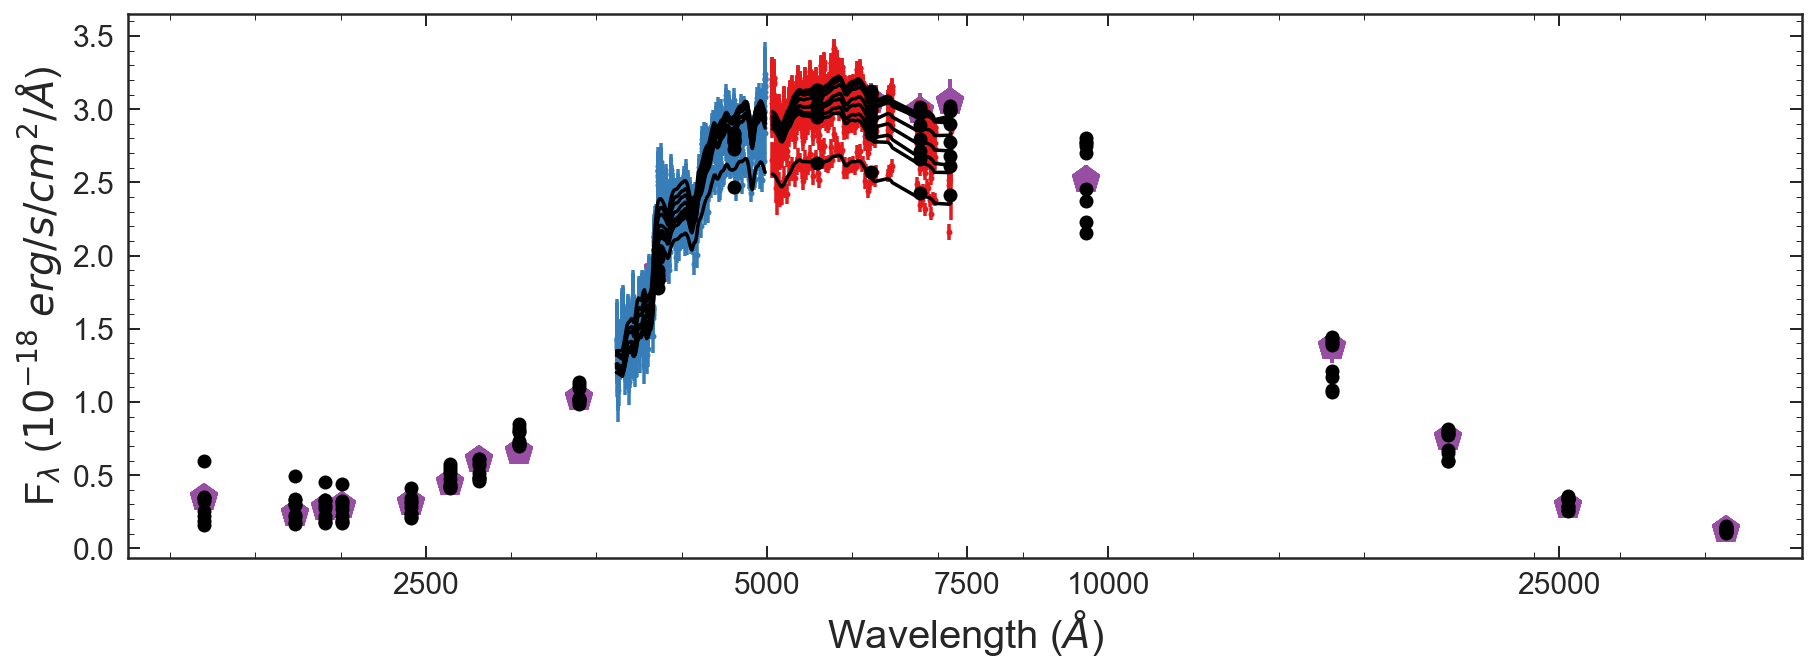

In [15]:

plt.figure(figsize=[15,5])

for u in range(50):
    draw = np.zeros(len(params))

    for i in range(len(draw)):
        draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

    sp.params['dust2'] = draw[13]
    sp.params['dust1'] = draw[13]
    sp.params['logzsol'] = np.log10(draw[0])

    time, sfr, tmax = convert_sfh(get_agebins(draw[1]), draw[2:12], maxage = draw[1]*1E9)

    sp.set_tabular_sfh(time,sfr)    

    wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)    

    Gs.Sim_all_premade(wave*( 1 + draw[12]),flux)
    
#     gcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [draw[14],draw[15]], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])
    
    gs = GridSpec(2,4, hspace=0.3, wspace = 0.3)   

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 ,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)
    
    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

# Create goodness dataframe

In [46]:
flist = glob('../data/posteriors/*tabfit_Pz*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [47]:
USE = np.repeat(True, len(fld))
Bllim = np.repeat(0, len(fld))
Bhlim = np.repeat(1E10, len(fld))
Rllim = np.repeat(0, len(fld))
Rhlim = np.repeat(1E10, len(fld))

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


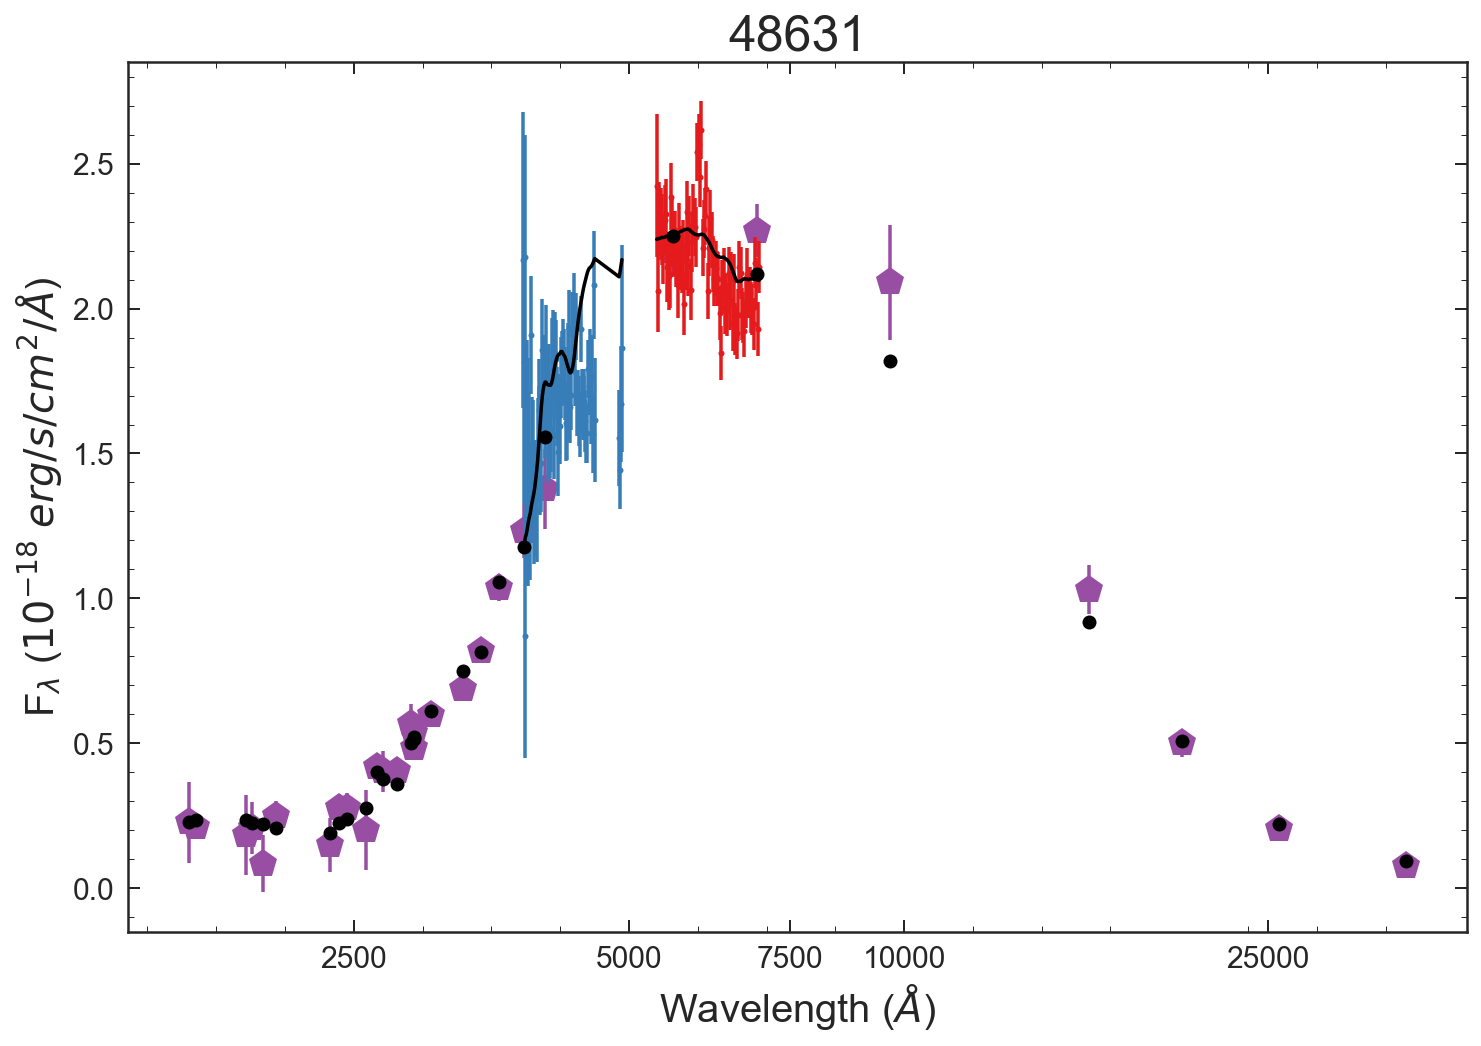

In [258]:
idx = 90

##################################################
#############Use criteria###################
field=fld[idx]
galaxy = ids[idx]

use_blim = None
use_rlim = None

USE[idx] = True

if use_blim != None:
    Bllim[idx] = use_blim[0]
    Bhlim[idx] = use_blim[1]
else:
    Bllim[idx] = 0
    Bhlim[idx] = 1E10

    
if use_rlim != None:
    Rllim[idx] = use_rlim[0]
    Rhlim[idx] = use_rlim[1]
else:
    Rllim[idx] = 0
    Rhlim[idx] = 1E10

#############################################
#############################################    

if USE[idx]:

    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bsc, rsc, bp1, \
    rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))

    Gs = Gen_spec(field, galaxy, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.04, irac_err = 0.08, decontam = True, Bselect = [Bllim[idx], Bhlim[idx]], Rselect = [Rllim[idx], Rhlim[idx]]) 

    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    

    wave, flux = sp.get_spectrum(tage = a, peraa = True)    

    Gs.Sim_all_premade(wave*(1+z),flux)

    # if Gs.g102 and Gs.g141:
    #     bcal, rcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [bp1,rp1], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])

    if Gs.g102:
    #     bcal = Calibrate_grism(Gs, [Gs.Bmfl], [bp1], [Gs.Bwv], [Gs.Bfl], [Gs.Ber])[0]
        bcal = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Gs.Bmfl, bp1)[0]

    if Gs.g141:
    #     rcal = Calibrate_grism(Gs, [Gs.Rmfl], [rp1], [Gs.Rwv], [Gs.Rfl], [Gs.Rer])[0]
        rcal = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Gs.Rmfl, rp1)[0]

    plt.figure(figsize=[12,8])
    ###############plot tab##################

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / bcal,Gs.Ber*1E18 / bcal,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18 /  rcal,Gs.Rer*1E18 / rcal,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)

    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
    plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)


In [269]:
selec_db = pd.DataFrame({'field':fld,'id':ids,'use':USE,'bllim':Bllim,'bhlim':Bhlim,'rllim':Rllim,'rhlim':Rhlim})

In [270]:
selec_db.to_pickle('../spec_files/section.pkl')

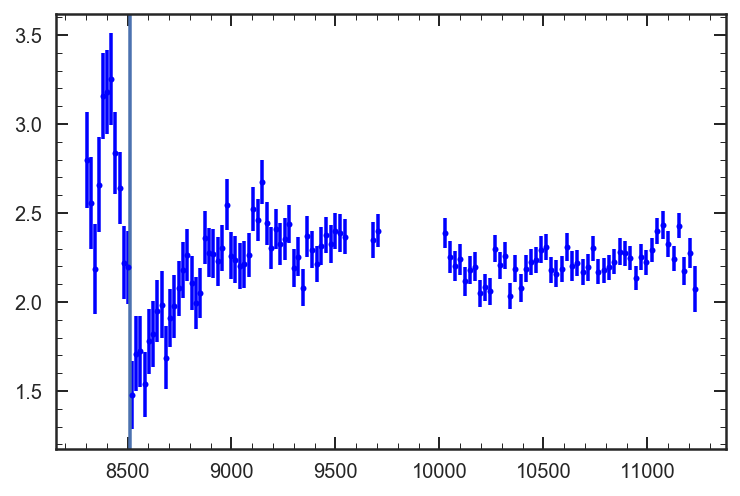

In [252]:
plt.errorbar(Gs.Bwv,Gs.Bfl*1E18, Gs.Ber*1E18,
            linestyle='None', marker='o', markersize=3, color='b', zorder = 2)
plt.axvline(8510)

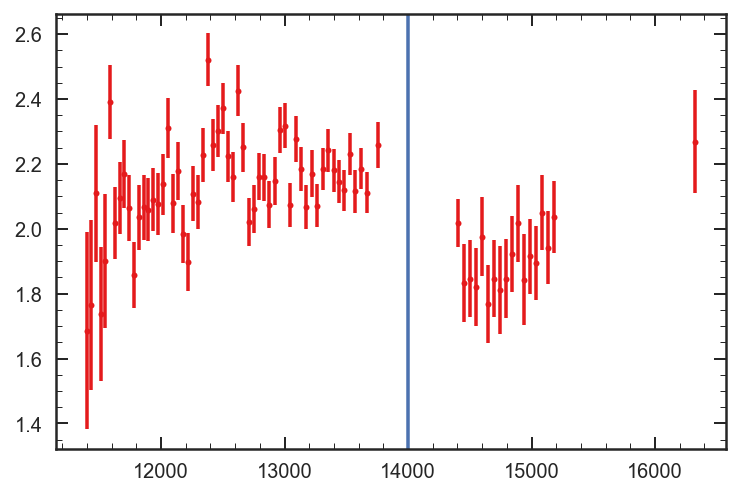

In [246]:
plt.errorbar(Gs.Rwv,Gs.Rfl*1E18, Gs.Rer*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
plt.axvline(14000
           )

In [127]:
Bllim

array([   0, 8475,    0,    0, 9400,    0,    0,    0,    0,    0,    0,
          0, 8900,    0,    0,    0,    0,    0,    0,    0,    0, 8600,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 9500,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [263]:
260-68

192

In [264]:
48*4

192

In [266]:
192*4+260

1028

In [275]:
selec_db.query('id == 39170').bllim.values[0]

0

In [271]:
selec_db

,bhlim,bllim,field,id,rhlim,rllim,use
0,1.000000e+10,0,GND,12078,1.000000e+10,13400,True
1,1.000000e+10,8475,GND,12793,1.000000e+10,0,True
2,1.000000e+10,0,GND,13182,1.000000e+10,0,True
3,1.000000e+10,0,GND,13774,1.000000e+10,0,True
4,1.000000e+10,9400,GND,14158,1.000000e+10,0,True
5,1.000000e+10,0,GND,14713,1.000000e+10,0,True
6,1.000000e+10,0,GND,15490,1.000000e+10,0,True
7,1.000000e+10,0,GND,15901,1.000000e+10,0,True
8,1.000000e+10,0,GND,16758,1.000000e+10,0,True
9,1.000000e+10,0,GND,17070,1.000000e+10,0,True
